<a href="https://colab.research.google.com/github/Krishij04/Deep-Learning/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Regularization Techniques for Deep Neural Networks
# Colab Implementation using SMS Spam Collection Dataset

# Install required packages
!pip install nltk
!pip install torch
!pip install tensorflow

# REMOVED: Google Drive mounting since it's causing an error
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Download the dataset directly (easier than using Kaggle API for this dataset)
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip -q smsspamcollection.zip
!rm smsspamcollection.zip

# Continue with the rest of the code as is...

replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# For NLP processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Training WITHOUT regularization:
Epoch 1: Train Acc = 0.3936 | Test Acc = 0.1365
Epoch 2: Train Acc = 0.4928 | Test Acc = 0.5120
Epoch 3: Train Acc = 0.5362 | Test Acc = 0.5421
Epoch 4: Train Acc = 0.5632 | Test Acc = 0.5812
Epoch 5: Train Acc = 0.5866 | Test Acc = 0.6233
Epoch 6: Train Acc = 0.5950 | Test Acc = 0.5888
Epoch 7: Train Acc = 0.6098 | Test Acc = 0.6730
Epoch 8: Train Acc = 0.6230 | Test Acc = 0.6631
Epoch 9: Train Acc = 0.6318 | Test Acc = 0.6812
Epoch 10: Train Acc = 0.6383 | Test Acc = 0.6877
Epoch 11: Train Acc = 0.6448 | Test Acc = 0.6732
Epoch 12: Train Acc = 0.6469 | Test Acc = 0.7189
Epoch 13: Train Acc = 0.6506 | Test Acc = 0.7001
Epoch 14: Train Acc = 0.6595 | Test Acc = 0.7400
Epoch 15: Train Acc = 0.6676 | Test Acc = 0.7391
Epoch 16: Train Acc = 0.6635 | Test Acc = 0.7463
Epoch 17: Train Acc = 0.6686 | Test Acc = 0.7055
Epoch 18: Train Acc = 0.6759 | Test Acc = 0.6512
Epoch 19: Train Acc = 0.6715 | Test Acc = 0.7513
Epoch 20: Train Acc = 0.6704 | Test Acc = 0.

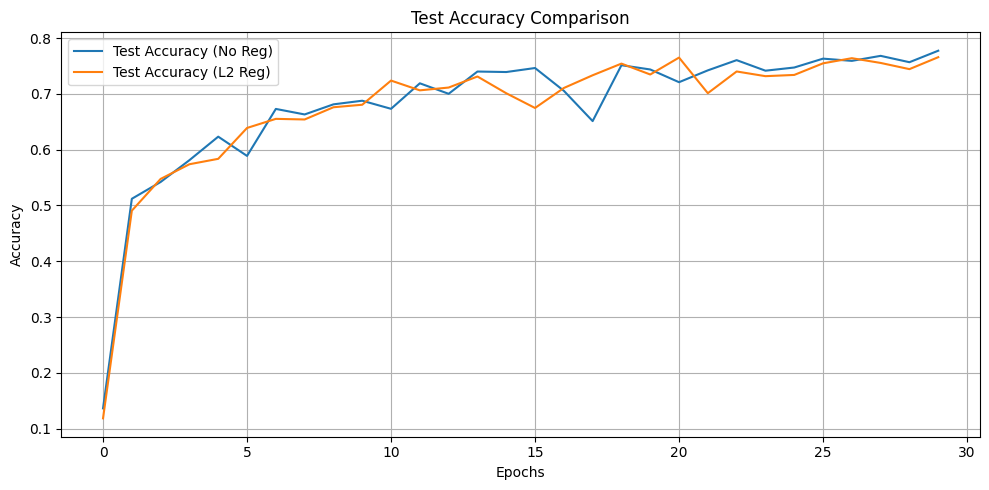

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Configuration
BATCH_SIZE = 128
EPOCHS = 30
IMAGE_SIZE = 32
NUM_CLASSES = 10
AUTO = tf.data.AUTOTUNE
LABEL_SMOOTHING = 0.1

# -----------------------------
# Utility functions
# -----------------------------
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE + 4, IMAGE_SIZE + 4)
    image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    return image, tf.one_hot(label, NUM_CLASSES)

def cutout(image, mask_size=16):
    cutout_center = tf.random.uniform([2], minval=0, maxval=IMAGE_SIZE, dtype=tf.int32)
    y, x = cutout_center[0], cutout_center[1]

    y1 = tf.clip_by_value(y - mask_size // 2, 0, IMAGE_SIZE)
    y2 = tf.clip_by_value(y + mask_size // 2, 0, IMAGE_SIZE)
    x1 = tf.clip_by_value(x - mask_size // 2, 0, IMAGE_SIZE)
    x2 = tf.clip_by_value(x + mask_size // 2, 0, IMAGE_SIZE)

    mask = tf.ones((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.reshape(tf.stack(tf.meshgrid(tf.range(y1, y2), tf.range(x1, x2), indexing='ij'), axis=-1), (-1, 2)),
        updates=tf.zeros((tf.maximum(y2 - y1, 1) * tf.maximum(x2 - x1, 1), 3))
    )
    return image * mask

def mixup(batch_x, batch_y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    index = tf.random.shuffle(tf.range(tf.shape(batch_x)[0]))
    mixed_x = lam * batch_x + (1 - lam) * tf.gather(batch_x, index)
    mixed_y = lam * batch_y + (1 - lam) * tf.gather(batch_y, index)
    return mixed_x, mixed_y

# -----------------------------
# Model builder
# -----------------------------
def build_model(l2_factor):
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_factor))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_factor))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_factor))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# -----------------------------
# Training function
# -----------------------------
def run_training(l2_factor, use_mixup=True, use_cutout=True):
    (ds_train, ds_test), _ = tfds.load('cifar10', split=['train', 'test'],
                                       as_supervised=True, with_info=True)

    ds_train = ds_train.map(preprocess, num_parallel_calls=AUTO).shuffle(5000)

    if use_cutout:
        def apply_cutout(image, label):
            return cutout(image), label
        ds_train = ds_train.map(apply_cutout, num_parallel_calls=AUTO)

    ds_train = ds_train.batch(BATCH_SIZE).prefetch(AUTO)
    ds_test = ds_test.map(preprocess, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

    model = build_model(l2_factor)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    train_acc = tf.keras.metrics.CategoricalAccuracy()
    test_acc = tf.keras.metrics.CategoricalAccuracy()

    train_accs, test_accs = [], []

    for epoch in range(EPOCHS):
        for images, labels in ds_train:
            if use_mixup:
                images, labels = mixup(images, labels)
            with tf.GradientTape() as tape:
                preds = model(images, training=True)
                loss = loss_fn(labels, preds) + sum(model.losses)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_acc.update_state(labels, preds)

        for test_images, test_labels in ds_test:
            preds = model(test_images, training=False)
            test_acc.update_state(test_labels, preds)

        t_acc = train_acc.result().numpy()
        v_acc = test_acc.result().numpy()
        print(f"Epoch {epoch+1}: Train Acc = {t_acc:.4f} | Test Acc = {v_acc:.4f}")

        train_accs.append(t_acc)
        test_accs.append(v_acc)
        train_acc.reset_state()
        test_acc.reset_state()

    return model, train_accs, test_accs

# -----------------------------
# Run both experiments
# -----------------------------
print("\nTraining WITHOUT regularization:")
model_no_reg, train_acc_no_reg, test_acc_no_reg = run_training(l2_factor=0.0)
model_no_reg.save("model_no_regularization.keras")

print("\nTraining WITH L2 regularization:")
model_with_reg, train_acc_reg, test_acc_reg = run_training(l2_factor=1e-4)
model_with_reg.save("model_with_l2_regularization.keras")


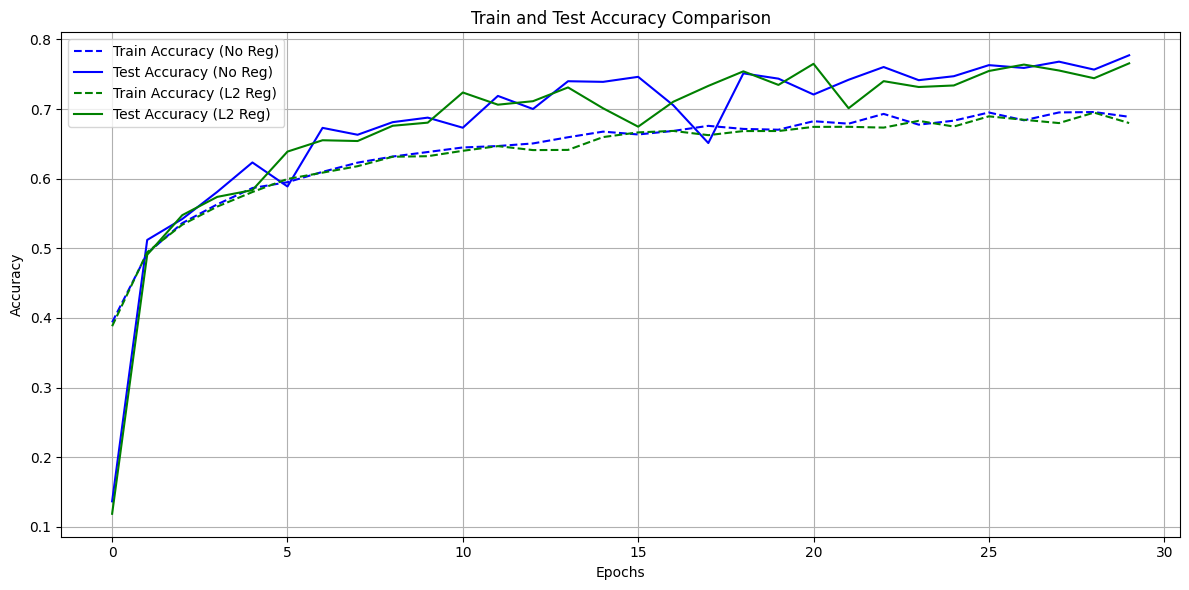

In [ ]:
# -----------------------------
# Plotting the results (Train + Test Accuracy)
# -----------------------------
plt.figure(figsize=(12, 6))

# Plotting No Regularization
plt.plot(train_acc_no_reg, label='Train Accuracy (No Reg)', linestyle='--', color='blue')
plt.plot(test_acc_no_reg, label='Test Accuracy (No Reg)', linestyle='-', color='blue')

# Plotting L2 Regularization
plt.plot(train_acc_reg, label='Train Accuracy (L2 Reg)', linestyle='--', color='green')
plt.plot(test_acc_reg, label='Test Accuracy (L2 Reg)', linestyle='-', color='green')

plt.title("Train and Test Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_test_accuracy_comparison.png")
plt.show()
